/anaconda/envs/Edward/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


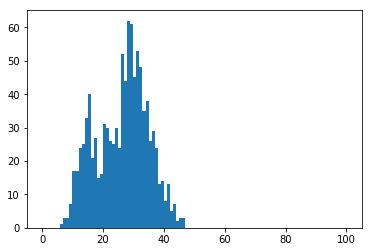

numpy.ndarray

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
from edward.models import (Categorical, Dirichlet, Empirical, Poisson,
                           Mixture, Gamma, ParamMixture, Normal,
                           InverseGamma, MultivariateNormalDiag)

#DATA
N = 1000
_lambda_0 = 15.0
_lambda_1 = 30.0
sess = ed.get_session()

dCat= Categorical([0.001, 0.999])
dPoi_0 = Poisson(_lambda_0)
dPoi_1 = Poisson(_lambda_1)

_x = Mixture(
    cat=dCat,
    components=[dPoi_0, dPoi_1]
)

x_data = sess.run(_x.sample(N))

plt.hist(x_data, bins=100, range=(0, 100))
plt.show()

display(type(x_data))
sess.close()
tf.flags.DEFINE_string('f', '', 'kernel')

In [2]:
from IPython.display import clear_output

K = 2
D = 2

# with tf.Graph().as_default():
sess = ed.get_session()
FLAGS = tf.flags.FLAGS

# MODEL
# すべてのカテゴリが等しい 
pi = Dirichlet(tf.ones(K))
alpha = Gamma(
    concentration=1. * 40.,
    rate=1. * 2.,
    sample_shape=K
)

x = ParamMixture(
    pi,
    {
        'rate': alpha,
    },
    Poisson,
    name="x",
    sample_shape=N
)
cat = x.cat

T = 100

# INFERENCE
qpi = Empirical(
    tf.get_variable(
        "qpi/params", [T, K],
        initializer=tf.constant_initializer(1.0 / K)
    )
)
qalpha = Empirical(tf.get_variable(
    "qalpha/params", [T, K],
    initializer=tf.ones_initializer())
)
qcat = Empirical(
    tf.get_variable(
        "qcat/params", [T, N],
        initializer=tf.zeros_initializer(),
        dtype=tf.int32
    )
)

inference = ed.Gibbs(
    {
        pi: qpi,
        alpha: qalpha,
        cat: qcat,
    },
    data={
        x: x_data
    }
)

inference.initialize()

tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qalpha.params[:t_ph], 0)
display(inference.n_iter)
for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))
inference.finalize()


/anaconda/envs/Edward/lib/python3.5/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


100

  1/100 [  1%]                                ETA: 20s | Acceptance Rate: nan
Inferred cluster means:
[nan nan]
  2/100 [  2%]                                ETA: 11s | Acceptance Rate: 1.000
Inferred cluster means:
[26.224451 25.612766]

Inferred cluster means:
[25.908974 25.726513]

Inferred cluster means:
[26.020477 25.686644]
  5/100 [  5%] █                              ETA: 4s | Acceptance Rate: 1.000 
Inferred cluster means:
[26.101616 25.662924]

Inferred cluster means:
[26.038147 25.670406]

Inferred cluster means:
[26.023453 25.717916]
  8/100 [  8%] ██                             ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[25.94872  25.854403]

Inferred cluster means:
[25.80263  26.045437]

Inferred cluster means:
[25.456944 26.4757  ]
 11/100 [ 11%] ███                            ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[24.94838  26.974808]

Inferred cluster means:
[24.582739 27.41318 ]

Inferred cluster means:
[24.135283 27.756073]
 14/100 [ 

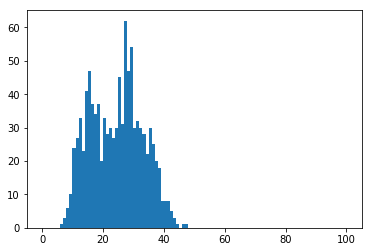

In [3]:
#DATA
N = 1000

_lambda = qpi.sample(N)

_lambda = qalpha.sample(N)
_lambda_0 = _lambda[:, 0]
_lambda_1 = _lambda[:, 1]
sess = ed.get_session()

dCat= Categorical(qpi.sample(N))
dPoi_0 = Poisson(_lambda_0)
dPoi_1 = Poisson(_lambda_1)

x_post = Mixture(
    cat=dCat,
    components=[dPoi_0, dPoi_1]
)

xp_data = sess.run(x_post)

plt.hist(xp_data, bins=100, range=(0, 100))
plt.show()


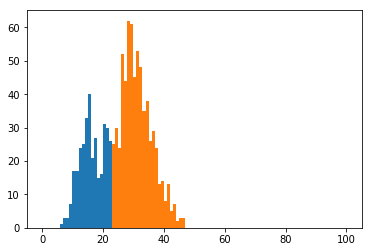

In [4]:
# 学習したパラメータLを利用して、事後分布を作る（L = {_lambda_0, _lambda_1}）
M = 100
L = qalpha.sample(M)
# 事後分布は（L = {_lambda_0, _lambda_1}）から作られる２つのポアソン分布
x_post = Poisson(L)

# データを２つのポアソン分布同時に評価するため、１次元から同じ数値のペアで構成される次元のデータに変換する
# [1, 2, 3] -> [[1, 1], [2, 2], [3, 3]]
# x_broadcasted = tf.tile(tf.reshape(x_data, [N, 1, 1]), [1, 1, K])

# # それぞれのポアソン分布での確率を求める
# log_liks = x_post.log_prob(x_broadcasted)
# log_liks = tf.reduce_sum(log_liks, 1)
# # 確率が大きい方を所属クラスタとする
# clusters = tf.argmax(log_liks, 1).eval()
# clusters

x_broadcasted = tf.tile(tf.reshape(x_data, [N, 1, 1]), [1, M, K])

# それぞれのポアソン分布での確率を求める
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 1)
# 確率が大きい方を所属クラスタとする
clusters = tf.argmax(log_liks, 1).eval()
clusters

df_result = pd.DataFrame({
    "c": clusters,
    "d": x_data,
    "a": log_liks.eval()[:, 0],
    "b": log_liks.eval()[:, 1],
})

plt.hist(df_result.pipe(lambda df: df[df['c'] == 0])['d'], bins=100, range=(0, 100))
plt.hist(df_result.pipe(lambda df: df[df['c'] == 1])['d'], bins=100, range=(0, 100))
plt.show()

In [5]:
# 学習したパラメータLを利用して、事後分布を作る（L = {_lambda_0, _lambda_1}）
N = 200
x_line = np.arange(1, N + 1).astype(np.float32)
M = 100
L = qalpha.sample(M)
# 事後分布は（L = {_lambda_0, _lambda_1}）から作られる２つのポアソン分布
x_post = Poisson(L)

x_broadcasted = tf.tile(tf.reshape(x_line, [N, 1, 1]), [1, M, K])

# それぞれのポアソン分布での確率を求める
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 1)
# 確率が大きい方を所属クラスタとする
clusters = tf.argmax(log_liks, 1).eval()
clusters


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

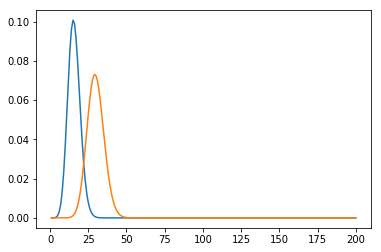

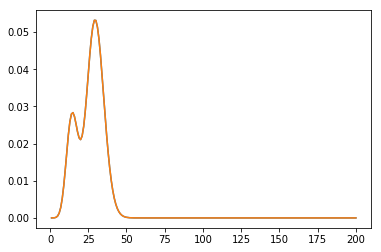

In [7]:
a = x_post.prob(x_broadcasted).eval()
plt.plot(x_line, a[:, 0])
plt.show()

a = _x.prob(x_broadcasted).eval()
plt.plot(x_line, a[:, 0])
plt.show()